# NEURAL NETWORKS AND DEEP LEARNING PROJECT

---
A.A. 2023/24 (6 CFU) - Giuseppe Labate, Sana Amiri
---

## Project 1 - Car classification, attribute prediction and car verification

In this project 

1.   **Classification** car images given cars dataset CompCars.

2.   **Attributes prediction** based on the images.  
        Attributes for this project are:  
    1. Explicit Attributes:  
    	1. Number of doors  
    	2. Number of seats  
    	3. Type of car  
	2. Implicit Attributes:  
    	4. Max speed  
    	5. Displacement  


In [6]:
## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
# %matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
# sns.set()  ---> Uncomment if you want to use seaborn themes

## tqdm for loading bars
from tqdm.notebook import tqdm

## NumPy
import numpy as np
## PyTorch
import torch
import torch.nn as nnpo
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision   # For Computer Vision tasks
from torchvision import transforms   # Transforms for images for data augmentation


# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "./Deep_Project/data/"
TRAIN_TEST_SPLIT_PATH = DATASET_PATH + "/train_test_split"
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = 0 #os.cpu_count()

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Device: cuda:0
Number of workers: 0


C:\Users\giuse\AppData\Local\Temp\ipykernel_41300\3828650873.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

In [7]:
import torchvision.models as models
from torchvision.models import ResNet50_Weights

# Carica un modello pre-addestrato su ImageNet
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Metti il modello in modalità di valutazione
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In the following cell, I will create a transformation composition that will be applied to the images in our dataset. This transformation is crucial for preprocessing the images before they are fed into our machine learning model. The preprocessing steps may include operations such as resizing, normalization, augmentation, and other techniques to enhance the quality and variability of the training data. By applying these transformations, we aim to improve the model's performance and generalization capabilities. Let's proceed with defining this transformation function in the next cell.

In [8]:
transform = transforms.Compose([
	transforms.Resize((224, 224)),
	transforms.ToTensor(),
	#transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In the next code snippet, we will perform DataLoading of the dataset contained in `./Deep_Project/data`. The dataset will be split according to the splitting files located in the `train_test_split` folder.

In [9]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class CarDataset(Dataset):
    def __init__(self, image_dir, label_dir, file_list, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.car_properties = []   # List of tuples (viewpoint, bbox)
        self.image_paths = []
        self.labels = []     # List of tuples (Car make, model, year) 
        						#--> it follows the directory structure car_make/car_model/year

        # Uploads the image paths and labels
        with open(file_list, 'r') as f:
            for line in f:
                image_path = os.path.join(image_dir, line.strip())
                label_path = os.path.join(label_dir, line.strip()).replace('.jpg', '.txt')
                self.image_paths.append(image_path)
                
                self.car_properties.append(self._load_label(label_path))
                
				#Dividing the label path into car make, model and year
                label_path = line.strip().split('/')
                self.labels.append((label_path[0], label_path[1], label_path[2]))

	#Loads the viewpoint and bounding box from the label file
    def _load_label(self, label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
            viewpoint = int(lines[0].strip())
            bbox = list(map(int, lines[2].strip().split()))
        return viewpoint, bbox

	#Returns the image, viewpoint, bounding box and label path
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert("RGB")
        car_properties = self.car_properties[index]
        labels = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, labels, car_properties

    def __len__(self):
        return len(self.image_paths)

print("Data loading is complete.")

Data loading is complete.


In [10]:
# Path to the folder where the datasets are/should be downloaded
image_dir = DATASET_PATH + "/image"
label_dir = DATASET_PATH + "/label"
train_list = DATASET_PATH + "/train_test_split/classification/train.txt"
test_list = DATASET_PATH + "/train_test_split/classification/test.txt"

# Create the datasets
train_dataset = CarDataset(image_dir=image_dir, label_dir=label_dir, file_list=train_list, transform=transform)
test_dataset = CarDataset(image_dir=image_dir, label_dir=label_dir, file_list=test_list, transform=transform)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)

Checking if the dataset is loaded correctly

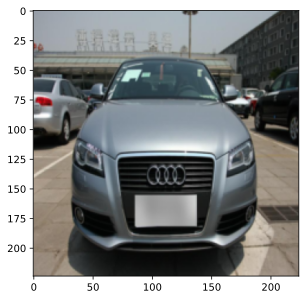

Labels: ('78', '1', '2010')
Car properties: (1, [131, 111, 765, 568])


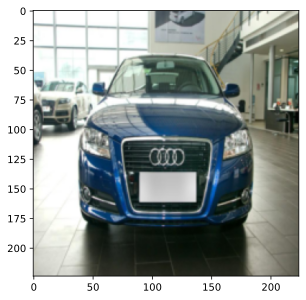

Labels: ('78', '1', '2010')
Car properties: (1, [154, 102, 752, 510])


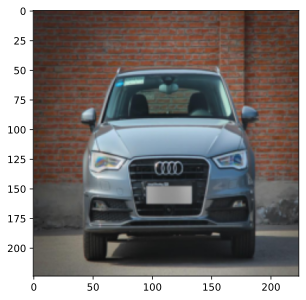

Labels: ('78', '1', '2014')
Car properties: (1, [162, 130, 771, 589])


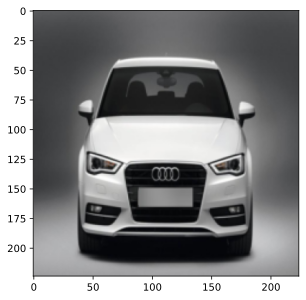

Labels: ('78', '1', '2013')
Car properties: (1, [151, 109, 763, 580])


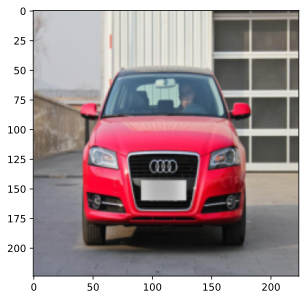

Labels: ('78', '1', '2012')
Car properties: (1, [160, 129, 745, 555])
Number of images in the training set: 16016
Number of images in the test set: 14939
Image shape: torch.Size([3, 224, 224])


In [13]:
#Print the number of images in the training and test sets
def imshow(img):
	#img = img / 2 + 0.5  # unnormalize
	npimg = img.numpy()
	plt.imshow(np.transpose(npimg, (1, 2, 0)))
	plt.show()

for i in range(5):
	img, labels, car_properties = train_dataset[i]
	imshow(img)
	print("Labels:", labels)
	print("Car properties:", car_properties)

print("Number of images in the training set:", len(train_dataset))
print("Number of images in the test set:", len(test_dataset))
print("Image shape:", img.shape)


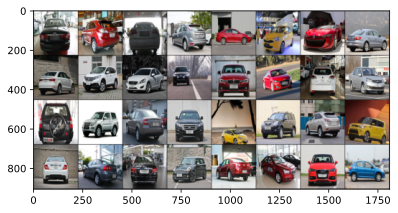

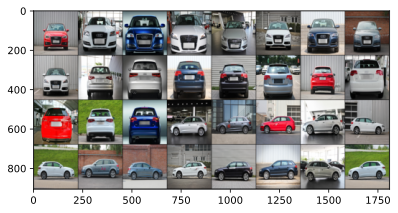

Number of training images: 16016
Number of test images: 14939


In [12]:
#Print the number of images in the training and test sets
def imshow(img):
	#img = img / 2 + 0.5  # unnormalize
	npimg = img.numpy()
	plt.imshow(np.transpose(npimg, (1, 2, 0)))
	plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels, car_prop = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Get some random test images
dataiter = iter(test_loader)
images, labels, car_prop = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print the total number of images in both sets
print(f"Number of training images: {len(train_loader.dataset)}")
print(f"Number of test images: {len(test_loader.dataset)}")